# MVP: Qualidade de Software, Segurança e Sistemas Inteligentes

# Análise de Churn em Telecom
Autor: Vitor Monteiro

# Introdução
O trabalho tem como objetivo desenvolver um modelo de machine learning para prever a evasão de clientes (churn) em uma empresa de telecomunicações, utilizando um conjunto de dados previamente tratado.

Este projeto segue as etapas fundamentais da criação de um sistema inteligente, conforme estudado na disciplina, incluindo: a carga e preparação dos dados, a avaliação de diferentes algoritmos de classificação, a otimização de seus hiperparâmetros e, por fim, a exportação do modelo mais performático para futura implementação no sistema de backend.

O processo será conduzido de forma metódica, utilizando pipelines para garantir a integridade do pré-processamento e validação cruzada para uma avaliação robusta e confiável dos modelos.

# Carga e Preparação dos Dados

## Importação das Bibliotecas e Carregamento dos Dados

A primeira etapa consiste na importação das bibliotecas essenciais para o projeto, como `pandas` para manipulação de dados, `matplotlib` para visualização e `scikit-learn` para todas as etapas de modelagem.

Em seguida, é realizada a carga do dataset a partir da URL fornecida e inspeção das primeiras linhas com o método `.head()` para garantir que os dados foram carregados corretamente.

In [1]:
# Importação das bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import pickle

# Definição da URL de acesso aos dados
url = 'https://raw.githubusercontent.com/vitorvmonteiro/mvp-sistemas-inteligentes/refs/heads/main/telecom_churn_clean_4V.csv'

# Leitura do arquivo .csv para um DataFrame do pandas
dataset = pd.read_csv(url, delimiter=';')

# Impressão das primeiras linhas para verificar a conformidade dos dados
dataset.head()

,customerID,international_plan,total_day_charge,total_eve_charge,customer_service_calls,churn
0,0,0,45.07,16.78,1,0
1,1,0,27.47,16.62,1,0
2,2,0,41.38,10.30,0,0
3,3,1,50.90,5.26,2,0
4,4,1,28.34,12.61,3,0


## Definição das Constantes e Separação de Dados (Holdout)

Definição das constantes que serão utilizadas ao longo do projeto:
  - Tamanho do conjunto de teste `TEST_SIZE`;
  - Semente aleatória `RANDOM_STATE` para garantir a reprodutibilidade dos resultados,
  - Métrica de avaliação `SCORING`.
  - `TARGET_COL` é Coluna alvo, o que o modelo vai tentar prever, afinal, é uma tarefa de aprendizado supervisionado.

Separação do dataset em variáveis de entrada `X` e a variável alvo `y`. A coluna `customerID` e a `TARGET_COL` são removidas dos dados de treino.

Por fim, é aplicada a estratégia de holdout, dividindo os dados em conjuntos de treino e teste usando a função `train_test_split`. O parâmetro `stratify=y` é usado para garantir que a proporção de clientes que cancelam (churn) e não cancelam seja a mesma tanto no conjunto de treino quanto no de teste, o que é crucial para uma avaliação justa do modelo, especialmente em datasets com classes desbalanceadas.

In [2]:
TEST_SIZE = 0.20      # Define que 20% do conjunto de dados será separado para testes.
RANDOM_STATE = 7      # Garante reprodutibilidade em todas as etapas aleatórias.
SCORING = 'accuracy'  # Define acurácia como métrica principal para avaliar o desempenho.
N_SPLITS_KFold = 10   # Indica que a validação cruzada dividirá o conjunto de treino em 10 partes (folds).
TARGET_COL = 'churn'  # Define a coluna alvo para a predição.

# Remove-se a coluna alvo e o identificador do cliente para criar o conjunto de features X
features_to_drop = [TARGET_COL, 'customerID']
X = dataset.drop(columns=features_to_drop)
y = dataset[TARGET_COL]

# O conjunto de dados é dividido para simular um cenário real onde o modelo é testado em dados que nunca viu.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

# Definição da estratégia de validação cruzada que será usada nos treinamentos
kfold = StratifiedKFold(n_splits=N_SPLITS_KFold, shuffle=True, random_state=RANDOM_STATE)

# Modelagem e Inferência

## Comparação de Modelos Clássicos sem Pré-processamento

A modelagem é iniciada criando um baseline. Esta etapa consiste em treinar diversos algoritmos de classificação (KNN, Árvore de Decisão, Naive Bayes e SVM) em sua forma padrão, sem qualquer transformação nos dados de entrada.

O objetivo é estabelecer um ponto de referência de performance. A avaliação é feita usando validação cruzada estratificada (StratifiedKFold), que treina e testa o modelo 10 vezes em diferentes subconjuntos dos dados de treino, fornecendo uma estimativa de desempenho muito mais robusta do que um único treino/teste.

Os resultados (acurácia média e desvio padrão) de cada modelo são impressos e visualizados em um boxplot para facilitar a comparação.

Performance dos Modelos (Baseline:

KNN: 0.8830 (0.0166)
CART: 0.8698 (0.0138)
NB: 0.8477 (0.0272)
SVM: 0.8710 (0.0034)


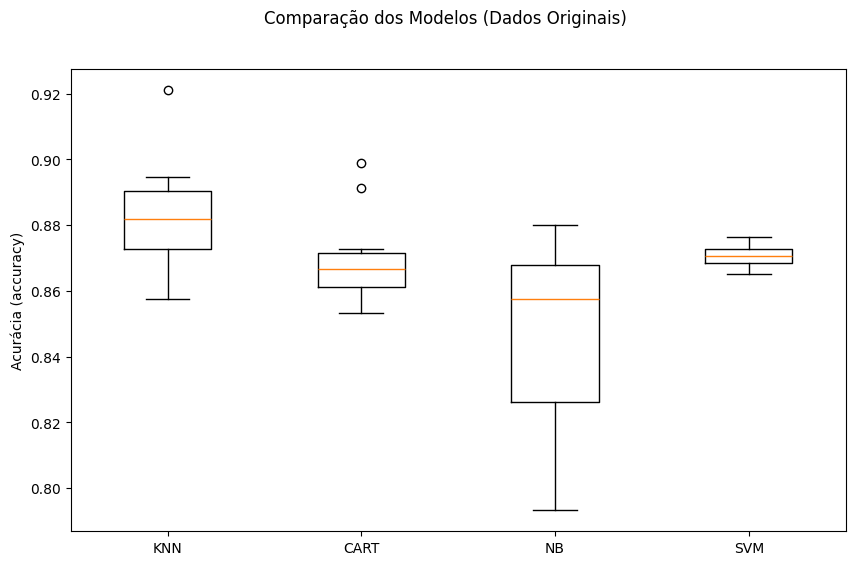

In [3]:
# Definição dos modelos a serem avaliados
models = {
    'KNN': KNeighborsClassifier(),
    'CART': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'NB': GaussianNB(),
    'SVM': SVC(random_state=RANDOM_STATE)
}

results = []
names = []

# Treinamento e avaliação de cada modelo usando validação cruzada
print("Performance dos Modelos (Baseline:\n")
for name, model in models.items():
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=SCORING)
    results.append(cv_results)
    names.append(name)
    # Imprime a acurácia média e o desvio padrão para cada modelo
    print(f"{name}: {cv_results.mean():.4f} ({cv_results.std():.4f})")

# Boxplot para comparação visual dos modelos
fig = plt.figure(figsize=(10, 6))
fig.suptitle('Comparação dos Modelos (Dados Originais)')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_ylabel(f'Acurácia ({SCORING})')
plt.show()

Nesse cenário o KNN é o modelo com melhor acurácia, com 88,30% de acerto.

## Avaliação do Impacto da Padronização e Normalização

Algoritmos como KNN e SVM são sensíveis à escala das variáveis. Portanto, duas técnicas comuns de pré-processamento serão aplicadas:

Padronização (StandardScaler): Transforma os dados para terem média 0 e desvio padrão 1.

Normalização (MinMaxScaler): Transforma os dados para um intervalo fixo, geralmente entre 0 e 1.

Para realizar essa avaliação de forma segura e eficiente, será utilizado `Pipeline`. Um pipeline encadeia múltiplas etapas (como um scaler e um modelo), garantindo que a transformação dos dados seja aplicada apenas nos dados de cada fold da validação cruzada, evitando o vazamento de informações (data leakage) e simplificando o fluxo de trabalho.

A performance de todos os modelos será avaliada e combinada com cada uma das técnicas de pré-processamento.

Performance dos Modelos com Pré-processamento:

--- KNN ---
KNN-Orig: 0.8830 (0.0166)
KNN-Padr: 0.8886 (0.0112)
KNN-Norm: 0.8867 (0.0142)
--- CART ---
CART-Orig: 0.8698 (0.0138)
CART-Padr: 0.8698 (0.0134)
CART-Norm: 0.8687 (0.0142)
--- NB ---
NB-Orig: 0.8477 (0.0272)
NB-Padr: 0.8477 (0.0272)
NB-Norm: 0.8477 (0.0272)
--- SVM ---
SVM-Orig: 0.8710 (0.0034)
SVM-Padr: 0.8961 (0.0108)
SVM-Norm: 0.8864 (0.0090)


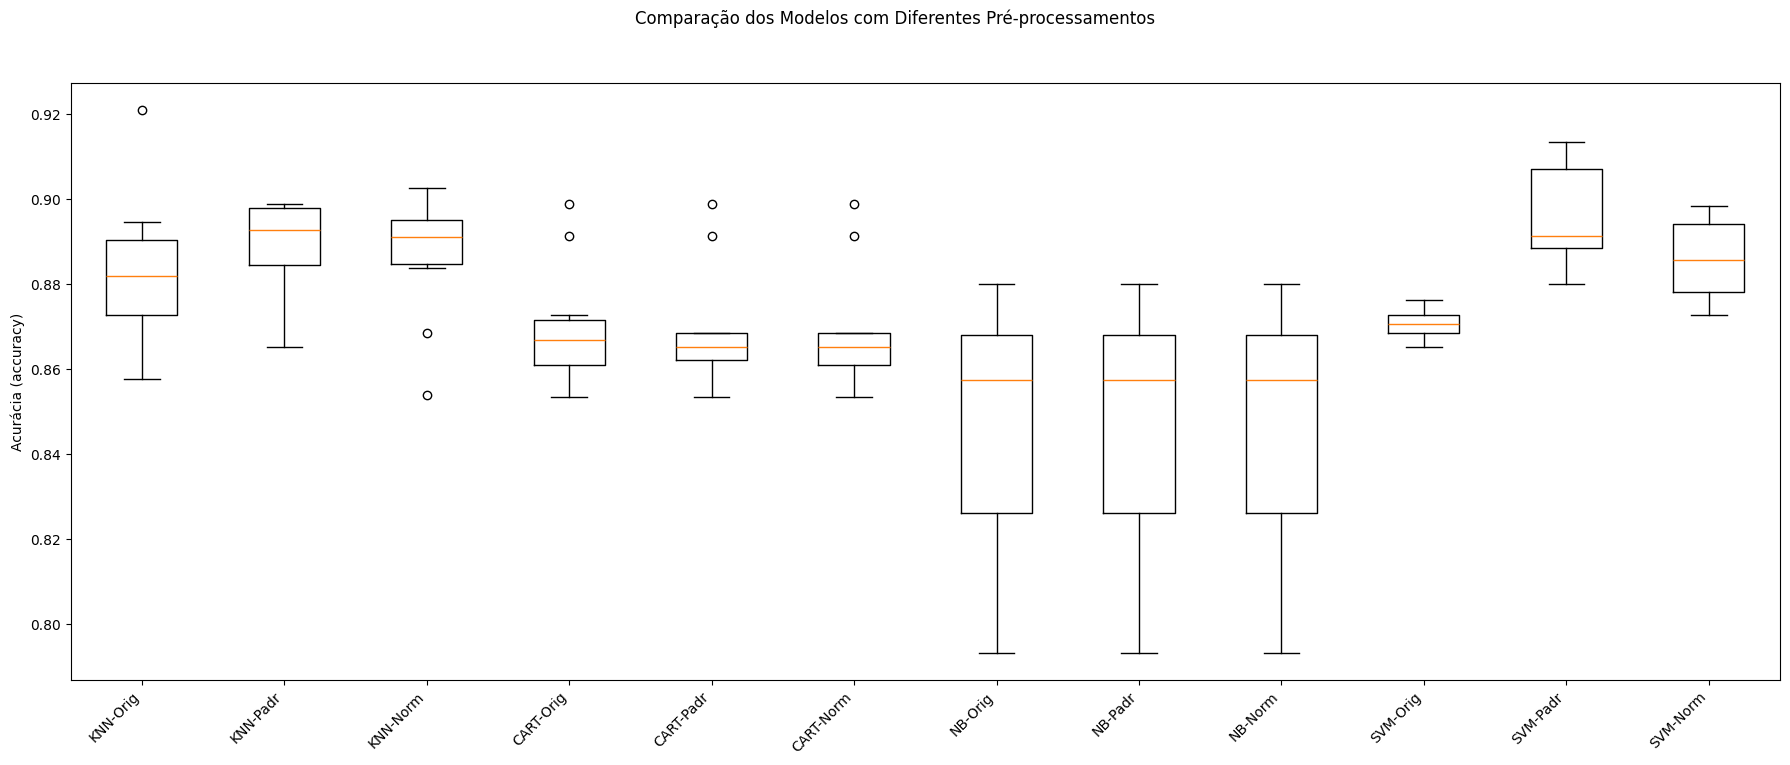

In [4]:
# Definição dos scalers a serem testados
scalers = {
    'Orig': None,  # 'Orig' representa o dado original, sem scaling
    'Padr': StandardScaler(),
    'Norm': MinMaxScaler()
}

pipelines_results = []
pipelines_names = []

# Loops aninhados para criar e avaliar pipelines de forma eficiente
# Cada modelo será testado com e sem cada tipo de scaler
print("Performance dos Modelos com Pré-processamento:\n")
for model_name, model_obj in models.items():
    print(f"--- {model_name} ---")
    for scaler_name, scaler_obj in scalers.items():
        steps = []
        # Adiciona o scaler ao pipeline apenas se ele for definido
        if scaler_obj:
            steps.append((scaler_name.lower(), scaler_obj))
        steps.append((model_name.lower(), model_obj))

        # Cria o pipeline
        pipeline = Pipeline(steps)
        pipeline_name = f"{model_name}-{scaler_name}"

        # Avalia o pipeline usando validação cruzada
        cv_results = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring=SCORING)

        pipelines_results.append(cv_results)
        pipelines_names.append(pipeline_name)

        print(f"{pipeline_name}: {cv_results.mean():.4f} ({cv_results.std():.4f})")

# Boxplot de comparação de todos os pipelines
fig = plt.figure(figsize=(18, 8))
fig.suptitle('Comparação dos Modelos com Diferentes Pré-processamentos')
ax = fig.add_subplot(111)
plt.boxplot(pipelines_results)
ax.set_xticklabels(pipelines_names, rotation=45, ha="right")
ax.set_ylabel(f'Acurácia ({SCORING})')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Os modelos melhoram com a padronização `StandardScaler` e com a normalização `MinMaxScaler`, exceto a Árvore de decisão que piorou levemente sua performance com a normalização. Naive Bayes não se alterou com padronização e normalização.

`StandardScaler` será usado para montar o pipeline final.

## Otimização de hiperparâmetros

Após identificar a melhor abordagem de pré-processamento, a próxima etapa é a otimização de hiperparâmetros.

Hiperparâmetros são as configurações "externas" de um modelo (ex: o número de vizinhos 'k' no KNN, ou o 'C' no SVM). Será utilizada a técnica `GridSearchCV`, que testa exaustivamente todas as combinações de hiperparâmetros definidas em um "grid" e, usando validação cruzada, identifica a combinação que resulta no melhor desempenho.

Este processo é aplicado a todos os quatro algoritmos, e o `GridSearchCV` automaticamente seleciona e retreina o melhor estimador (best_estimator_) para cada um.

In [5]:
# Baseado na análise anterior, será usado StandardScaler para todos os modelos no tuning
pipeline_knn = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
pipeline_cart = Pipeline([('scaler', StandardScaler()), ('cart', DecisionTreeClassifier(random_state=RANDOM_STATE))])
pipeline_nb = Pipeline([('scaler', StandardScaler()), ('nb', GaussianNB())])
pipeline_svm = Pipeline([('scaler', StandardScaler()), ('svm', SVC(random_state=RANDOM_STATE))])

# Para cada modelo, definimos um dicionário com os hiperparâmetros a serem testados.
# A sintaxe 'nomepasso__parametro' é usada para especificar parâmetros dentro de um pipeline.
param_grid_knn = {
    'knn__n_neighbors': [5, 7, 9, 11, 13, 15],
    'knn__metric': ["euclidean", "manhattan"]
}
param_grid_cart = {
    'cart__criterion': ['gini', 'entropy'],
    'cart__max_depth': [None, 5, 10, 15],
    'cart__min_samples_split': [2, 5, 10]
}
param_grid_nb = {
    'nb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}
param_grid_svm = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 'auto'],
    'svm__kernel': ['rbf']
}

# Execução do GridSearchCV para cada modelo
all_grid_results = []
models_to_tune = [
    ('KNN', pipeline_knn, param_grid_knn),
    ('CART', pipeline_cart, param_grid_cart),
    ('NB', pipeline_nb, param_grid_nb),
    ('SVM', pipeline_svm, param_grid_svm)
]

print("Otimizando Hiperparâmetros com GridSearchCV:\n")
for name, pipeline, param_grid in models_to_tune:
    print(f"--- Otimizando o modelo: {name} ---")
    # n_jobs=-1 utiliza todos os processadores disponíveis para acelerar o processo
    grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=SCORING, cv=kfold, n_jobs=-1)
    grid.fit(X_train, y_train)

    # Guarda as informações importantes de cada grid
    result_info = {
        'name': name,
        'score': grid.best_score_,
        'params': grid.best_params_,
        'estimator': grid.best_estimator_
    }
    all_grid_results.append(result_info)

    print(f"Melhor Acurácia para {name}: {grid.best_score_:.4f}")
    print(f"Melhores Parâmetros: {grid.best_params_}\n")

# --- Identificação do Melhor Modelo Geral ---
# Compara todos os modelos otimizados para encontrar o grande campeão
best_model_info = max(all_grid_results, key=lambda item: item['score'])
best_model = best_model_info['estimator'] # O melhor pipeline (scaler + modelo com os melhores parâmetros)

print("\n\nRESULTADO FINAL DA OTIMIZAÇÃO")
print(f"O melhor modelo é o: '{best_model_info['name']}'")
print(f"Ele alcançou uma acurácia de validação cruzada de: {best_model_info['score']:.4f}")
print(f"Com os seguintes hiperparâmetros: {best_model_info['params']}")

Otimizando Hiperparâmetros com GridSearchCV:

--- Otimizando o modelo: KNN ---
Melhor Acurácia para KNN: 0.8961
Melhores Parâmetros: {'knn__metric': 'manhattan', 'knn__n_neighbors': 15}

--- Otimizando o modelo: CART ---
Melhor Acurácia para CART: 0.8999
Melhores Parâmetros: {'cart__criterion': 'gini', 'cart__max_depth': 5, 'cart__min_samples_split': 2}

--- Otimizando o modelo: NB ---
Melhor Acurácia para NB: 0.8477
Melhores Parâmetros: {'nb__var_smoothing': 1e-09}

--- Otimizando o modelo: SVM ---
Melhor Acurácia para SVM: 0.8984
Melhores Parâmetros: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}



RESULTADO FINAL DA OTIMIZAÇÃO
O melhor modelo é o: 'CART'
Ele alcançou uma acurácia de validação cruzada de: 0.8999
Com os seguintes hiperparâmetros: {'cart__criterion': 'gini', 'cart__max_depth': 5, 'cart__min_samples_split': 2}


# Avaliação final do modelo

## Performance no Conjunto de Teste

Até agora, todas as avaliações foram feitas no conjunto de treino (usando validação cruzada). A etapa final e mais importante é avaliar a performance do melhor modelo no conjunto de teste (`X_test`, `y_test`), que foi separado no início e mantido intocado. Isso dá uma estimativa não enviesada de como o modelo se comportará em dados novos, do mundo real.

In [6]:
# O 'best_model' já foi treinado pelo GridSearchCV com os melhores parâmetros no conjunto de treino completo
# Agora, usamos o conjunto de teste para uma avaliação final e imparcial
predictions = best_model.predict(X_test)

# Acurácia Final
accuracy = accuracy_score(y_test, predictions)
print(f"\n Acurácia final no conjunto de teste: {accuracy:.4f}")




 Acurácia final no conjunto de teste: 0.8936


# Exportação do Modelo para Produção

## Treinamento com Todos os Dados e Salvamento do Modelo
Com o melhor modelo e os melhores hiperparâmetros definidos, o passo final é treinar o modelo utilizando todo o conjunto de dados (X e y). Essa prática visa aproveitar ao máximo toda a informação disponível antes de implantar o modelo em um ambiente de produção.

Após o treinamento final, o objeto do modelo (o pipeline completo) é serializado e salvo em um arquivo .pkl usando a biblioteca pickle. Este arquivo contém todo o necessário (o scaler e o modelo treinado) e pode ser facilmente carregado no backend da aplicação para fazer previsões em novos dados.

In [7]:
# Treina o modelo campeão com TODOS os dados disponíveis (treino + teste)
# para maximizar o aprendizado antes de ir para produção.
final_model = best_model.fit(X, y)

print(f"\nModelo final ('{best_model_info['name']}') foi treinado com todo o dataset.")
print(f"Usando a configuração de parâmetros: {best_model_info['params']}")

# Define o nome do arquivo para exportação
filename = 'modelo_churn.pkl'

# Abre o arquivo em modo de escrita binária ('wb') e salva o objeto do modelo final
with open(filename, 'wb') as file:
    pickle.dump(final_model, file)

print(f"\n✅ Modelo salvo com sucesso no arquivo: '{filename}'")


Modelo final ('CART') foi treinado com todo o dataset.
Usando a configuração de parâmetros: {'cart__criterion': 'gini', 'cart__max_depth': 5, 'cart__min_samples_split': 2}

✅ Modelo salvo com sucesso no arquivo: 'modelo_churn.pkl'


# Análise de resultados e conclusão

O processo de desenvolvimento do modelo de previsão de churn seguiu uma abordagem estruturada em três etapas principais.

1. Baseline: A avaliação inicial dos modelos nos dados brutos mostrou que os modelos selecionados apresentavam uma performance promissora com acurácia na faixa dos 86%+.

2. Pré-processamento: Foi observado que a aplicação de `StandardScaler` (Padronização) trouxe um ganho de performance, elevando a acurácia e confirmou a importância desta etapa.

3. Otimização de Hiperparâmetros: Utilizando GridSearchCV, foi possível refinar ainda mais os modelos. O melhor modelo foi a **Árvore de Decisão**, que, após o ajuste de seus hiperparâmetros alcançou a maior acurácia na validação cruzada, com aproximadamente 90%.

Na avaliação final sobre o conjunto de teste, o modelo de Árvore de Decisão demonstrou sua robustez, atingindo uma acurácia final de 89,36%.

## Conclusão
Este trabalho cumpriu com sucesso o objetivo de construir, avaliar e otimizar um modelo de classificação para o problema de churn. O modelo de Árvore de decisão, combinado com a padronização dos dados, foi identificado como a solução mais performática. O artefato final, `modelo_churn.pkl`, está pronto para ser integrado ao sistema de backend, onde poderá ser utilizado para prever proativamente a evasão de clientes.